# Synthesize Intensity: Out-of-Phase Cooling with Non-equilibrium Ionization

In [11]:
import os
import time
import h5py

import numpy as np
import astropy.units as u
from astropy.visualization import SqrtStretch,ImageNormalize,AsinhStretch,LogStretch
import sunpy.sun.constants
import matplotlib.pyplot as plt
import matplotlib.colors
import dask
import distributed

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.atomic import EmissionModel, Element
from synthesizAR.interfaces import EbtelInterface
from synthesizAR.visualize import plot_aia_channels

%matplotlib inline

In [2]:
client = distributed.Client()

In [3]:
client

Client Scheduler: tcp://127.0.0.1:42720 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


Load field and emission model

In [3]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/field_checkpoint/')

In [5]:
em_model = EmissionModel.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_emission_model.json')

## Population Fractions

In [6]:
nei_futures = em_model.calculate_ionization_fraction(field,
                                                     '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/nei/ionization_fractions.h5',
                                                    interface=EbtelInterface)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/distributed/worker.py:739: UserWarning: Large object of size 1.96 MB detected in task graph: 
  (['compute_and_save_nei-a2e667a2130d1dc10255e55789 ... _fractions.h5')
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s))


In [7]:
nei_futures.release()

In [8]:
em_model.save('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/nei/emission_model.json')

In [5]:
# Restore emission model here as needed
em_model = EmissionModel.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/nei/emission_model.json')

## Flatten Detector Counts

In [4]:
aia = InstrumentSDOAIA([0,30000]*u.s,)

In [6]:
observer = synthesizAR.Observer(field, [aia], parallel=True)

In [7]:
observer.build_detector_files('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/nei/',
                              0.5 * u.Mm)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


In [12]:
flatten_futures = observer.flatten_detector_counts(emission_model=em_model)

## Build Intensity Maps

In [9]:
bin_futures = observer.bin_detector_counts('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/nei/')

## Visualize

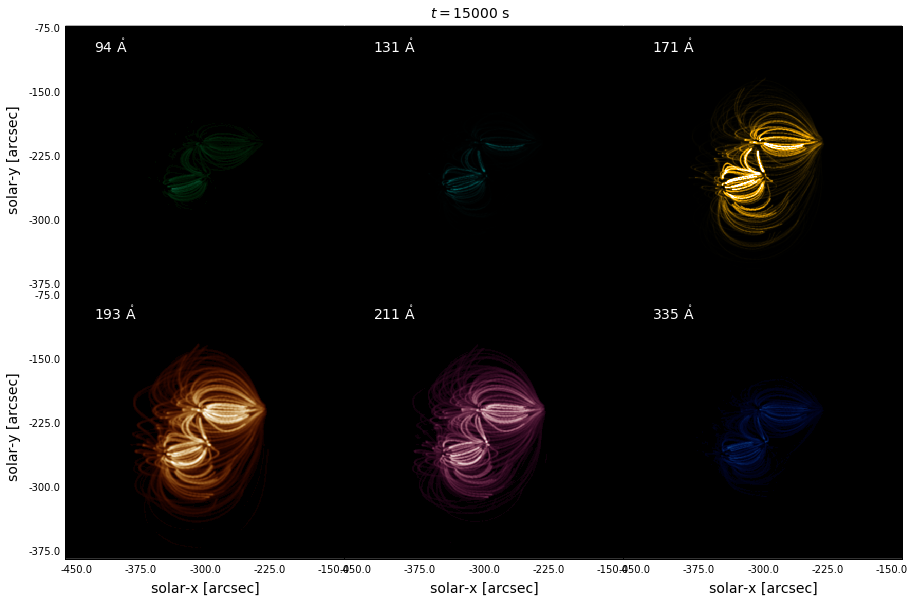

In [17]:
plot_aia_channels(aia,15000 * u.s, '/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/nei/',
                  norm=ImageNormalize(vmin=0,vmax=3e2,stretch=AsinhStretch()),
                  figsize=(15,8.975))